In [1]:
import os
import numpy as np
from scipy.fftpack import dct
from scipy.signal import cwt
from pywt import dwt2
from skimage.io import imread, imshow
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from IPython import display

from utils import (
    SoftThresh,
    ShrinkageOperator,
    Proj
)

%matplotlib inline

## Import an image to compress and reconstruct

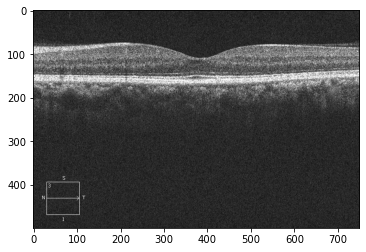

In [14]:
image_path = "OCTID_NORMAL"
image_name = "NORMAL10.jpeg"
image = os.path.join(image_path, image_name)

oct_image = imread(image)
plt.imshow(oct_image, cmap='gray')

# Taking the first of the 3 channels, as they are all the same.
compression_factor = 2
h, w = X.shape
mask = np.random.binomial(size=(h, w), n=1, p=1/compression_factor)
plt.imshow(oct_image, cmap='gray')

In [35]:
basis_ = "dct"

if basis_ == "dct":
    B1 = dct(np.eye(h), norm='ortho', axis=0).T
    B2t = dct(np.eye(w), norm='ortho', axis=0)
else: 
    # pywt.dwt2 is the discrete wavelet transform in 2D. It returns the transformed array
    # in 4 equaly sized block matrices which are simplpy regions of the entire 2D transform
    (cA, (cH, cV, cD)) = dwt2(np.eye(h), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B1 = np.concatenate([upper, lower], axis=1)
    
    (cA, (cH, cV, cD)) = dwt2(np.eye(w), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B2t = np.concatenate([upper, lower], axis=1)

D = X*mask
W = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

tau_sparse = 3
tau_low_rank = 30
a = 1

In [36]:
def Update1(mask, B1, B2t, W, D, a):
    # Minimize the error with respect to constraint P_{\Omega}(B1 @ W @ B2t) == P_{\Omega}
    Z = Proj(B1 @ W @ B2t, mask) - D
    Z = B1.T @ Z @ B2t.T
    return W - a*Z

Iteration 1:	Reconstruction Error: 32044.94	Spectral Norm W: 421005.43	Sparisty of W: 85074.84
Resulting Reconstruction after 0 interations:


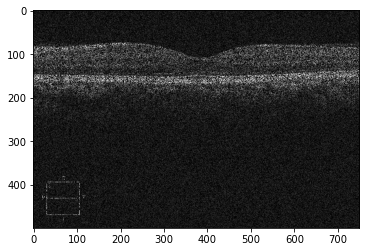

Iteration 51:	Reconstruction Error: 10281.10	Spectral Norm W: 194298.84	Sparisty of W: 134337.27
Iteration 101:	Reconstruction Error: 6813.95	Spectral Norm W: 173166.24	Sparisty of W: 152662.90
Iteration 151:	Reconstruction Error: 6683.76	Spectral Norm W: 173255.98	Sparisty of W: 154760.73
Iteration 201:	Reconstruction Error: 6671.55	Spectral Norm W: 173312.46	Sparisty of W: 155057.69
Iteration 251:	Reconstruction Error: 6669.62	Spectral Norm W: 173323.52	Sparisty of W: 155109.97
Resulting Reconstruction after 250 interations:


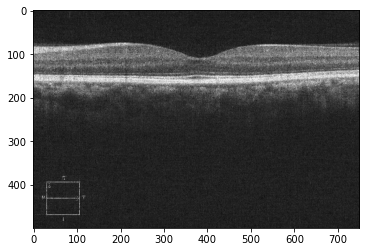

Iteration 301:	Reconstruction Error: 6669.25	Spectral Norm W: 173325.67	Sparisty of W: 155120.30
Iteration 351:	Reconstruction Error: 6669.18	Spectral Norm W: 173326.12	Sparisty of W: 155122.46
Iteration 401:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.21	Sparisty of W: 155122.93
Iteration 451:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.23	Sparisty of W: 155123.03
Iteration 501:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Resulting Reconstruction after 500 interations:


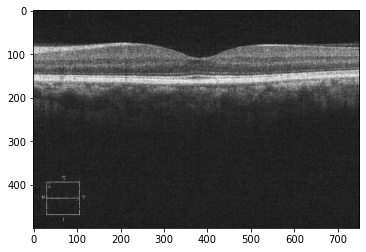

Iteration 551:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 601:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 651:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 701:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 751:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Resulting Reconstruction after 750 interations:


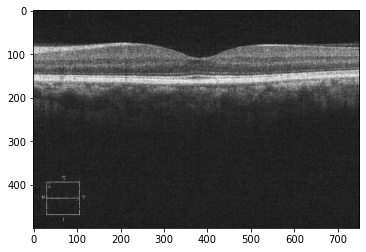

Iteration 801:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 851:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 901:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06
Iteration 951:	Reconstruction Error: 6669.16	Spectral Norm W: 173326.24	Sparisty of W: 155123.06


 Final Reconstruction


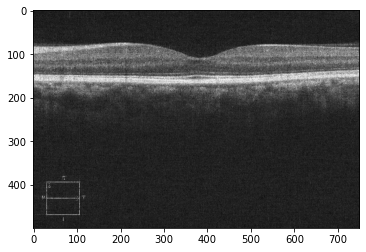

In [37]:
W_ = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

reconstruction_error_l1 = []
spectral_norm_l1 = []
sparsity_l1 = []

iters = 1000
for i in range(iters):
    W_ = Update1(mask, B1, B2t, W_, D, a)

    if i % 2 == 0:
        W_ = ShrinkageOperator(W_, tau_low_rank)
    else:
        W_ = SoftThresh(W_, tau_sparse)
    
    spectral_norm_l1.append(np.linalg.norm(W_, ord="nuc"))
    sparsity_l1.append(np.linalg.norm(W_, ord=1))
    reconstruction_error_l1.append(np.linalg.norm(X - B1 @ W_ @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error_l1[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm_l1[-1]:.2f}\t"\
            f"Sparisty of W: {sparsity_l1[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W_ @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W_ @ B2t, cmap="gray");

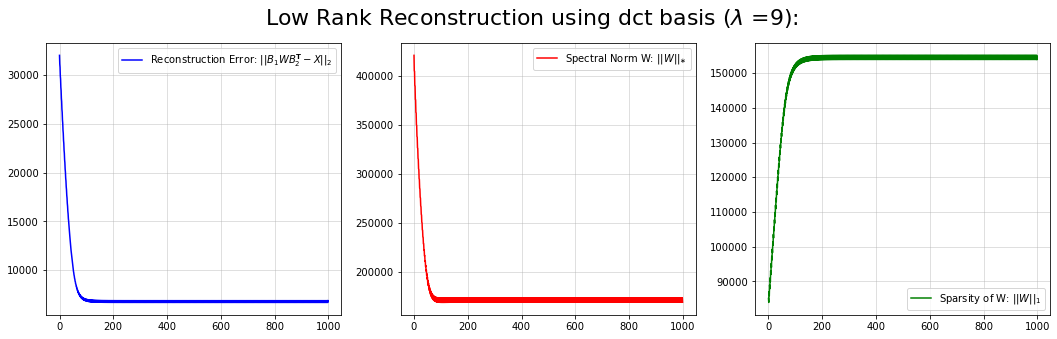

Resulting Reconstruction:


<Figure size 1008x648 with 0 Axes>

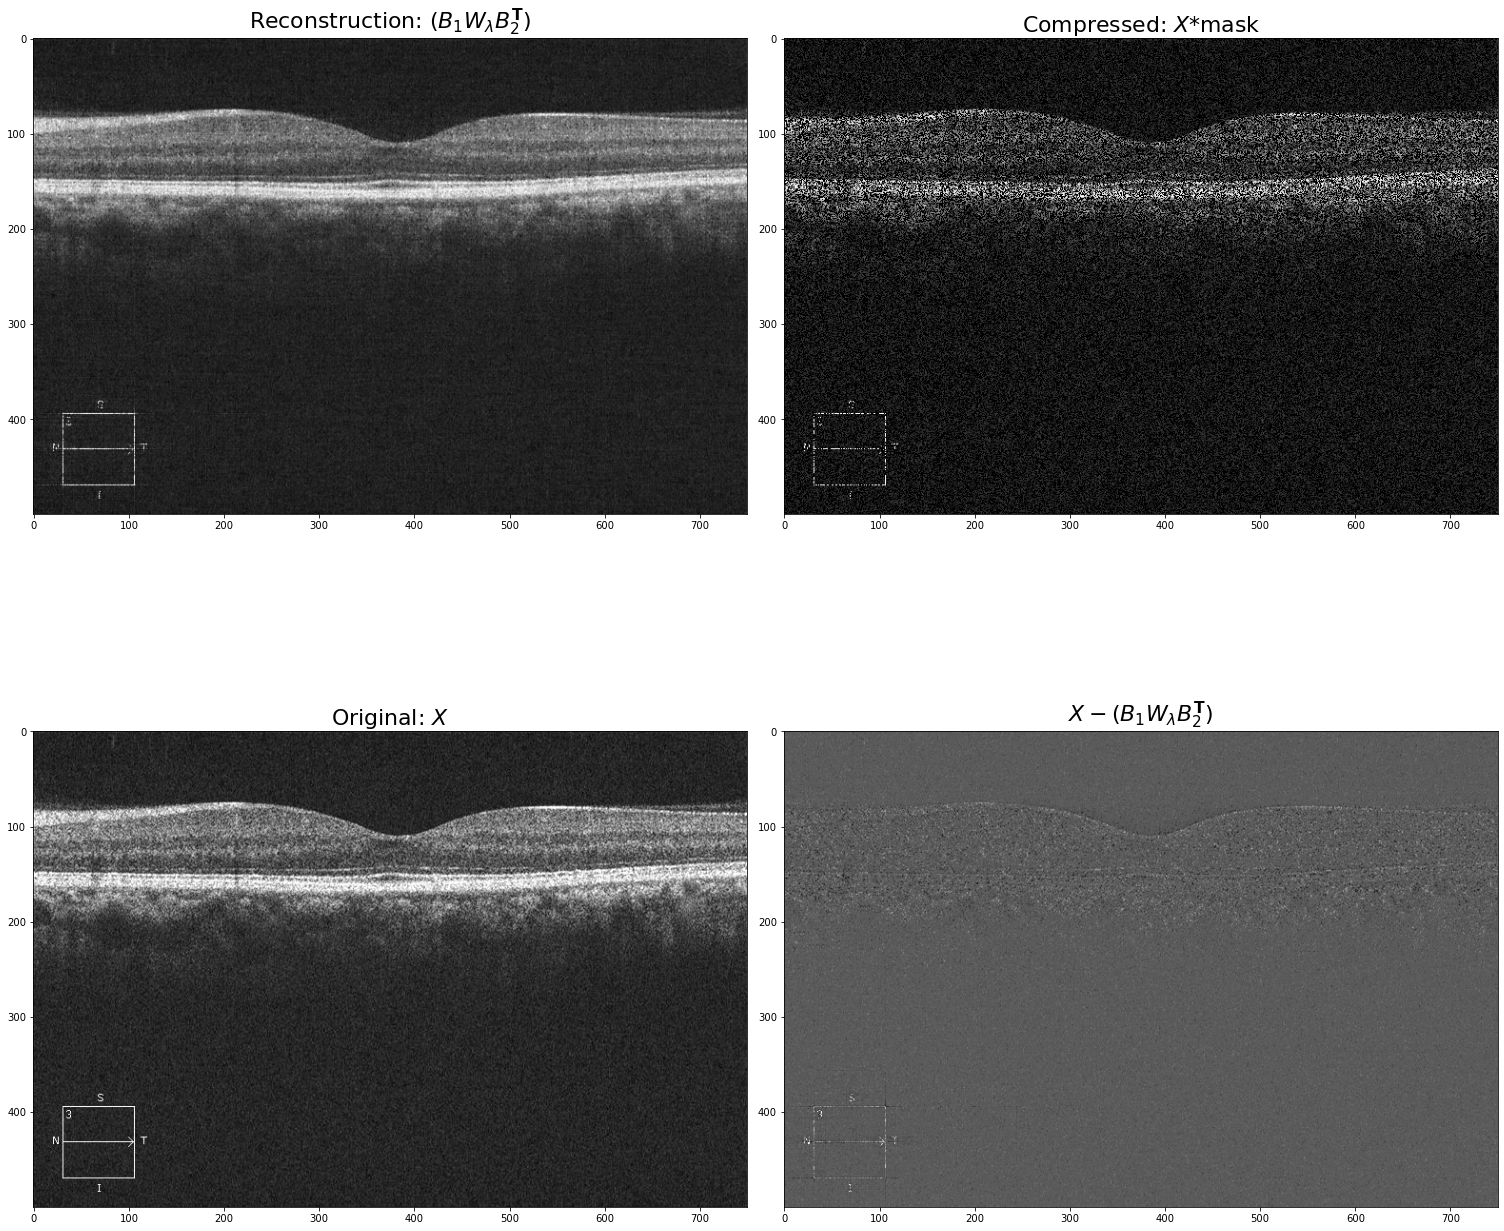

In [38]:
lbda_ = 9
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(reconstruction_error_l1, c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(spectral_norm_l1, c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(sparsity_l1, c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

fig.suptitle(f"Low Rank Reconstruction using {basis_} basis " + r"($\lambda$ =" + f"{lbda_}):", fontsize=22)

plt.show();

print(f"Resulting Reconstruction:")
plt.figure(figsize=(14, 9));
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 21))

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=22)
axes[0][0].imshow(B1 @ W_ @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=22)
axes[0][1].imshow(X*mask, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=22)
axes[1][0].imshow(X, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=22)
axes[1][1].imshow(X - (B1 @ W_ @ B2t), cmap="gray")

plt.tight_layout()
plt.show()